# Stock Price Analysis with Python – DINOPL Case Study

This notebook demonstrates a structured analysis of daily stock prices for the company **Dino Polska (DINOPL)**. We'll walk through:

- Importing and preparing the data
- Calculating daily logarithmic returns
- Visualizing stock trends and return distributions
- Evaluating rolling statistical indicators (volatility, skewness, kurtosis)
- Generating professional-quality plots for financial insight

This kind of analysis can be easily scaled to multiple assets or used as the basis for a portfolio risk study.


## Load and Prepare the Data

We import daily stock prices for Dino Polska (DINOPL) from an Excel file. The dataset includes dates and corresponding closing prices. We also set a clean column name and remove the index label for clarity.

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import skew, kurtosis

# Load stock data from Excel
data_path = 'C:/Users/Nico/Desktop/python/dane/STOCKS.xlsx'
dino = pd.read_excel(data_path, sheet_name='DINOPL', header=None, index_col=0, parse_dates=True)
dino.columns = ['Price']
dino.index.name = None

## First Glimpse at the Data

Before proceeding, it's crucial to inspect the first few rows of the dataset to understand its structure and ensure it's correctly formatted.

In [13]:
dino.head(3)

,Price
2017-04-19,37.50
2017-04-20,38.00
2017-04-21,39.19


## Calculate Logarithmic Daily Returns
Logarithmic returns convert the data into a stationary process, allowing for the application of statistical methods.

In [14]:
dino['Log_Returns'] = np.log(dino['Price'] / dino['Price'].shift(1))
log_returns = dino['Log_Returns'].dropna()
log_returns.head(3)

2017-04-20    0.013245
2017-04-21    0.030835
2017-04-24    0.004328
Name: Log_Returns, dtype: float64

## Visualizing Price and Returns

This chart shows the original stock price along with its daily log returns. Such visualizations are useful to detect volatility spikes or structural shifts in the data.

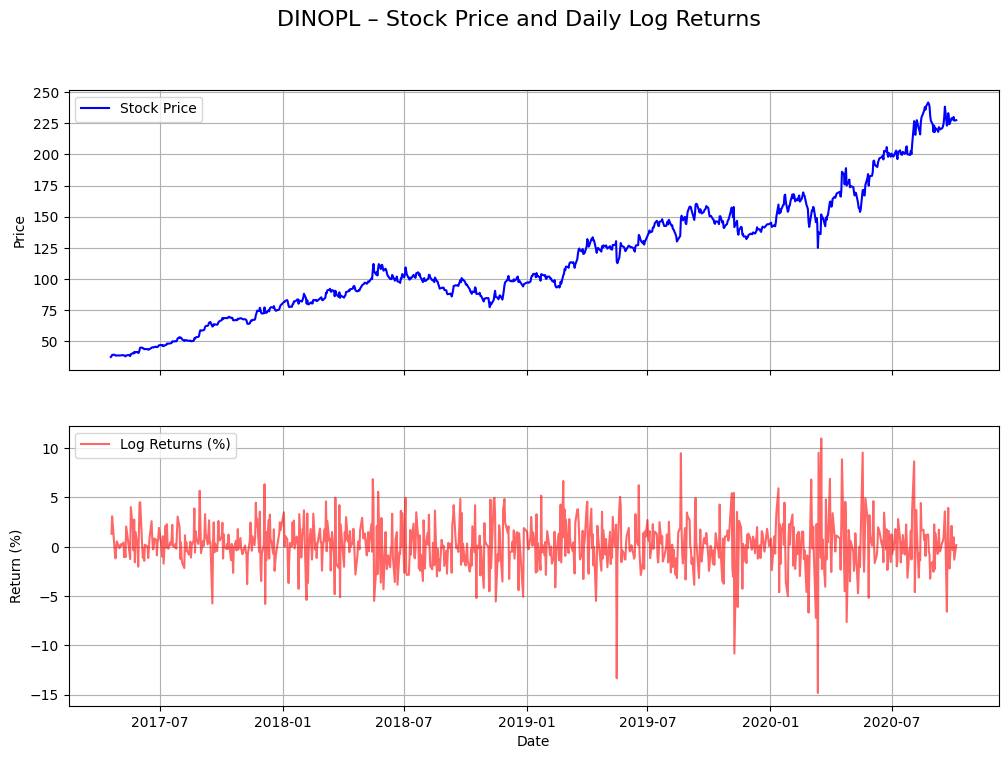

In [15]:
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

axs[0].plot(dino.index, dino['Price'], label='Stock Price', color='blue')
axs[0].set_ylabel("Price")
axs[0].legend()
axs[0].grid()

axs[1].plot(log_returns.index, log_returns * 100, label='Log Returns (%)', color='red', alpha=0.6)
axs[1].set_ylabel("Return (%)")
axs[1].legend()
axs[1].grid()

plt.xlabel("Date")
plt.suptitle("DINOPL – Stock Price and Daily Log Returns", fontsize=16)
plt.show()

## Return Distribution

We compare the empirical histogram of log returns to a normal distribution. This helps assess whether returns are Gaussian – an assumption often made in finance, but rarely met in practice.

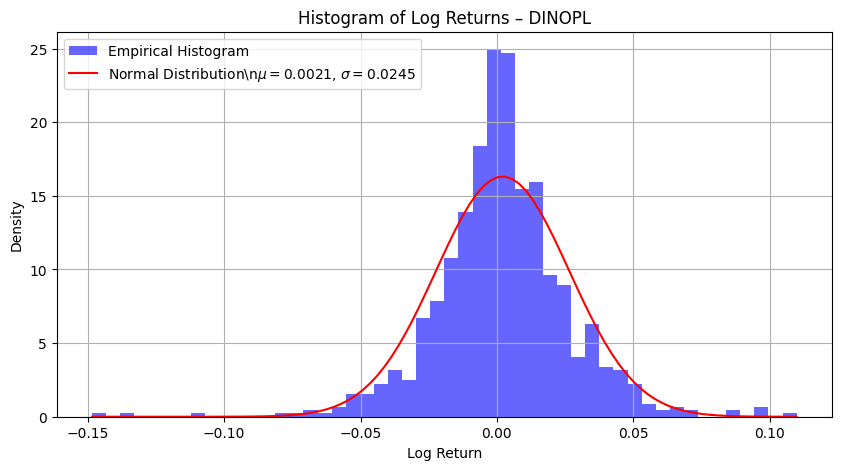

Skewness: -0.2347
Kurtosis: 7.1469


In [16]:
mu, sigma = log_returns.mean(), log_returns.std()
x = np.linspace(log_returns.min(), log_returns.max(), 100)
pdf = stats.norm.pdf(x, mu, sigma)

plt.figure(figsize=(10, 5))
plt.hist(log_returns, bins=50, density=True, alpha=0.6, color='b', label='Empirical Histogram')
plt.plot(x, pdf, 'r', label=fr'Normal Distribution\n$\mu={mu:.4f}$, $\sigma={sigma:.4f}$')
plt.title("Histogram of Log Returns – DINOPL")
plt.xlabel("Log Return")
plt.ylabel("Density")
plt.legend()
plt.grid()
plt.show()
# Calculate skewness and kurtosis
skewness = stats.skew(log_returns)
kurt = stats.kurtosis(log_returns, fisher=False)  # fisher=False → kurtosis = 3 for normal dist

print(f"Skewness: {skewness:.4f}")
print(f"Kurtosis: {kurt:.4f}")

### Is the distribution really normal?

This histogram shows that DINOPL's log returns **are not perfectly Gaussian**:

- The red line is the fitted normal distribution.
- The blue bars (empirical data) show:
  - Slight **positive skewness** – the right tail is longer.
  - **High kurtosis** – more extreme values and a sharper peak.

This behavior is quite typical for financial return series.

## Quantile-Quantile (Q-Q) Plot

The Q-Q plot is used to compare the quantiles of the returns to a standard normal distribution. Deviations from the straight line indicate skewness or kurtosis in the data.

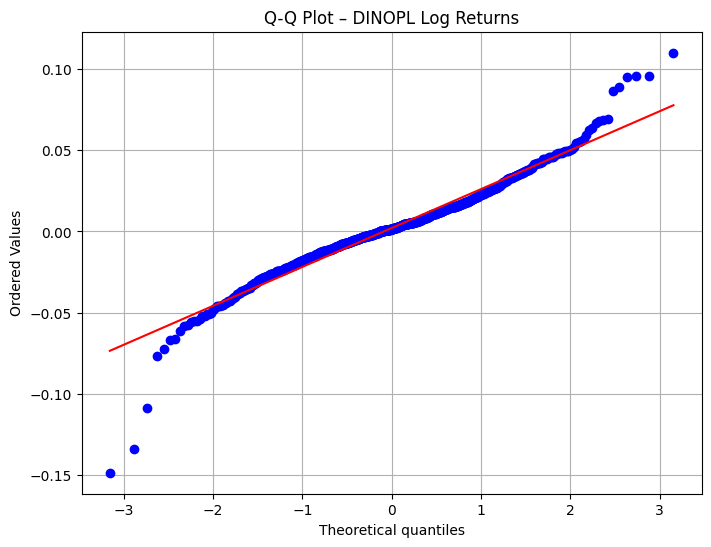

In [17]:
plt.figure(figsize=(8, 6))
stats.probplot(log_returns, dist="norm", plot=plt)
plt.title("Q-Q Plot – DINOPL Log Returns")
plt.grid()
plt.show()

### Q-Q Plot – DINOPL Log Returns

This Quantile-Quantile (Q-Q) plot compares the empirical distribution of log returns for DINOPL with a normal distribution.

- If the returns were normally distributed, the points would lie along the red line.
- Deviations in the tails (both left and right) indicate the presence of **fat tails**, meaning extreme values (large losses or gains) occur more frequently than predicted by a normal distribution.
- This is a common feature in financial data, suggesting higher risk and the presence of "black swan" events.

Such deviations confirm our earlier finding of elevated kurtosis and possibly non-zero skewness.


In [18]:
rolling = log_returns.to_frame()
rolling['Moving_Avg_250'] = rolling['Log_Returns'].rolling(window=250).mean()
rolling['Std_250'] = rolling['Log_Returns'].rolling(window=250).std()
rolling['Skew_250'] = rolling['Log_Returns'].rolling(window=250).apply(lambda x: skew(x, bias=False), raw=True)
rolling['Kurt_250'] = rolling['Log_Returns'].rolling(window=250).apply(lambda x: kurtosis(x, bias=False), raw=True)

rolling[['Moving_Avg_250', 'Std_250', 'Skew_250', 'Kurt_250']].dropna().tail()

,Moving_Avg_250,Std_250,Skew_250,Kurt_250
2020-09-29,0.001465,0.029556,-0.251671,4.324059
2020-09-30,0.001489,0.029550,-0.254106,4.331311
2020-10-01,0.001625,0.029508,-0.266321,4.375535
2020-10-02,0.001647,0.029496,-0.268074,4.388376
2020-10-05,0.001651,0.029495,-0.268525,4.388604


## Rolling Volatility & Distribution Metrics (250 days)

We compute 250-day rolling metrics to capture how the distribution of returns evolves over time. These can help detect risk shifts, tail events, or changing market dynamics.

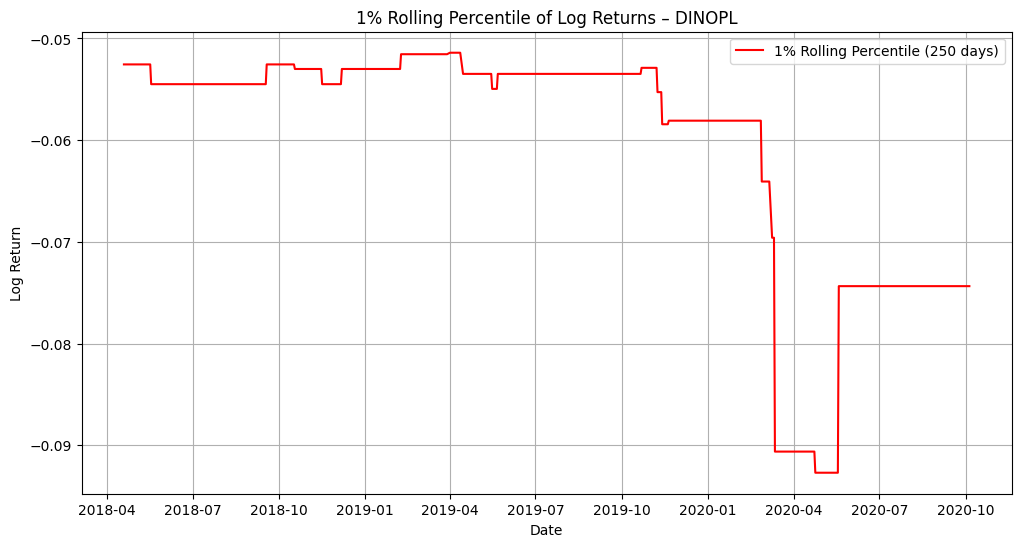

In [19]:
rolling['Perc_1_250'] = rolling['Log_Returns'].rolling(window=250).quantile(0.01)
rolling['Range_250'] = rolling['Log_Returns'].rolling(window=250).apply(lambda x: np.max(x) - np.min(x), raw=True)
rolling['Q1_250'] = rolling['Log_Returns'].rolling(window=250).quantile(0.25)
rolling['Q3_250'] = rolling['Log_Returns'].rolling(window=250).quantile(0.75)

plt.figure(figsize=(12, 6))
plt.plot(rolling.index, rolling['Perc_1_250'], label='1% Rolling Percentile (250 days)', color='red')
plt.title('1% Rolling Percentile of Log Returns – DINOPL')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()
plt.grid()
plt.show()

## Percentile & Range Indicators

In addition to standard metrics, we compute quantile-based risk indicators like the 1% percentile (left-tail risk) and interquartile range (volatility spread).

Plot shows the 1st percentile of DINOPL's log returns over a rolling 250-day window.

- The **1% percentile** represents the extreme left tail of the return distribution.
- It helps identify periods where the stock experienced **unusually large negative returns**.
- Monitoring the 1% percentile over time is particularly useful for **risk management** and **stress testing**, as it highlights periods of elevated downside risk.

## Conclusion

This notebook demonstrates how to:

- Clean and prepare financial time series
- Calculate and analyze log returns
- Visualize price movements and distribution properties
- Evaluate rolling risk indicators